In [1]:
import tensorflow
print(tensorflow.__version__)

C:\Users\shaha\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shaha\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shaha\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shaha\anaconda3\envs\tensor\lib\site-packages\tensorflow\pyth

1.14.0


In [2]:
# Install MTCNN library for face detection
!pip install mtcnn

In [4]:
# Import required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.models import Model,model_from_json, load_model
from tensorflow.keras.layers import Layer,Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

In [5]:
# Define Encoder Model Architecture ( Inception-ResNet-v1 )
model_path = "Models/Inception_ResNet_v1.json" 

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
enc_model = model_from_json(loaded_model_json)

In [6]:
# Set encoder model to be trainable
enc_model.trainable = True

In [9]:
# model_path = "Models/Inception_ResNet_v1.json"
# weights_path = "Models/enc_model_weights.h5"

enc_model = load_model(model_path)

In [7]:
# Initialize a MTCNN face detector
mtcnn_detector = MTCNN()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Function to detect and extract face from a image
def detect_face(filename, required_size=(160, 160)):

	img = Image.open(filename)
	
  # convert to RGB
	img = img.convert('RGB')
 
	# convert to array
	pixels = np.asarray(img)
 
	# detect faces in the image
	results = mtcnn_detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']

	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height

	# extract the face
	face = pixels[y1:y2, x1:x2]
  
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
 
	return face_array

In [9]:
# Detect and store faces(with labels) in the training dataset
# Update dataset path according to your working environment

cropped_faces =[]
face_labels = []

dataset_path = "LFW_dataset"

i=0

for person in os.listdir(dataset_path):
  for filename in os.listdir(os.path.join(dataset_path,person)):

    # Detect faces
    try :
      face = detect_face(dataset_path+'/'+person+'/'+filename)
    except:
      print(filename  + " can't be loaded !")
      continue    
    cropped_faces.append (face)

    # Save labels
    label = person
    face_labels.append(label)

    i+=1
    if i%50 == 0 :
      print(str(i)+" images loaded !") 
    
print("\nTotal "+str(i)+" images loaded !")

face_labels = np.array(face_labels)
cropped_faces = np.array(cropped_faces)
print(face_labels.shape)
print(cropped_faces.shape)  

50 images loaded !
100 images loaded !
150 images loaded !
200 images loaded !

Total 200 images loaded !
(200,)
(200, 160, 160, 3)


In [10]:
# Compute No. of IDs loaded
n_IDs = len(np.unique(face_labels))
print(n_IDs)

20


Hillary_Clinton


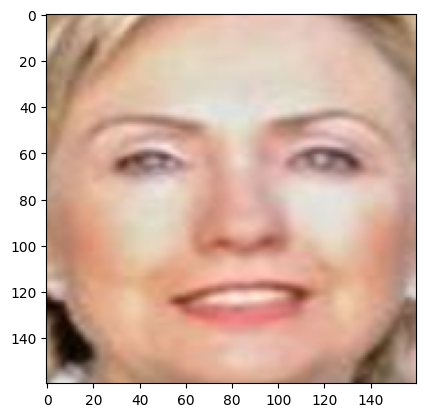

In [11]:
# Visualize dataset loaded
index = 70

plt.imshow(cropped_faces[index])
print(face_labels[index])

In [12]:
# Function to find Euclidean distance between 2 Faces

def distance(a,b):

  a/= np.sqrt(np.maximum(np.sum(np.square(a)),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b)),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b)))

  return dist

In [13]:
# Function to find Euclidean distances between 2 batch of Faces

def distance_batch(a,b):

  a/= np.sqrt(np.maximum(np.sum(np.square(a),axis=1,keepdims=True),1e-10))
  b/= np.sqrt(np.maximum(np.sum(np.square(b),axis=1,keepdims=True),1e-10))

  dist = np.sqrt(np.sum(np.square(a-b),axis=1))

  return dist

In [14]:
# Function to normalize a Single face

def normalize_single(X):

  axis = (0,1,2)

  mean = np.mean(X,axis)
  std = np.std(X,axis)

  size= X.size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [15]:
# Function to normalize a Batch of faces

def normalize_batch(X):

  axis = (1,2,3)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return X

In [16]:
# Function to normalize a Triplet batch

def normalize_triplet_batch(X):

  axis = (2,3,4)

  mean = np.mean(X,axis,keepdims=True)
  std = np.std(X,axis,keepdims=True)

  size = X[0][0].size
  adj_std = np.maximum(std,1/np.sqrt(size))

  X = (X-mean)/adj_std
  return [X[0],X[1],X[2]]

In [17]:
import numpy as np

# Generate all possible Anchor-Positive Combinations 

X_anchor = []
X_positive = []

X_anchor_labels = []
X_positive_labels = []  

persons_list = np.unique(face_labels)

for person in persons_list:
    filter_person = (face_labels == person).reshape(cropped_faces.shape[0])
    X_person = cropped_faces[filter_person]

    for face1 in range(X_person.shape[0]):#X_person shape (10,160,160,3)
        for face2 in range(face1 + 1, X_person.shape[0]):
            X_anchor.append(X_person[face1])
            X_positive.append(X_person[face2])

            X_anchor_labels.append(person)
            X_positive_labels.append(person)  # Both images are from the same person

# Convert lists to numpy arrays
X_anchor = np.array(X_anchor)
X_positive = np.array(X_positive)
X_anchor_labels = np.array(X_anchor_labels)
X_positive_labels = np.array(X_positive_labels)  

print(X_anchor.shape)
print(X_positive.shape)
print("Labels for Anchor and Positive are consistent:", np.all(X_anchor_labels == X_positive_labels))


(900, 160, 160, 3)
(900, 160, 160, 3)
Labels for Anchor and Positive are consistent: True


In [18]:
# Function to generate a batch of Triplets ( Anchor-Positive-Negative )
def get_batch(n_rand_triplets,n_hard_triplets):

  # Generate n_rand_triplets no. of Random Triplets
  filter = np.random.choice(list(range(0,X_anchor.shape[0])),int(n_rand_triplets))
  X_anchor_random  = X_anchor[filter]
  X_positive_random = X_positive[filter]
  X_negative_random = []
  X_anchor_random_labels = X_anchor_labels[filter]

  for i in range(int(n_rand_triplets)):
    flag=False
    while(flag==False):
      index = np.random.randint(0,cropped_faces.shape[0])
      if face_labels[index]!=X_anchor_random_labels[i]:
        X_negative_random.append(cropped_faces[index])
        flag=True

  X_negative_random = np.array(X_negative_random)
  # If only hard triplets required
  if n_rand_triplets == 0:
    X_negative_random = X_anchor_random # Empty arrays 
    
  # Generate n_hard_triplets no. of Hard Triplets ( Positive distance > Negative distance )
  X_negative_samples = []

  for i in range(X_anchor.shape[0]):

    flag=False
    while(flag==False):
      index = np.random.randint(0,cropped_faces.shape[0])
      if face_labels[index]!=X_anchor_labels[i]:
        X_negative_samples.append(cropped_faces[index])
        flag=True
    
  X_negative_samples = np.array(X_negative_samples)  
  Negative_distances = distance_batch(enc_model.predict(normalize_batch(X_anchor)),
                                      enc_model.predict(normalize_batch(X_negative_samples)))
  Positive_distances = distance_batch(enc_model.predict(normalize_batch(X_anchor)),
                                      enc_model.predict(normalize_batch(X_positive)))
  distances =  Negative_distances - Positive_distances
  filter = np.argsort(distances)[:int(n_hard_triplets)]
  X_anchor_hard = X_anchor[filter]
  X_positive_hard = X_positive[filter]
  X_negative_hard = X_negative_samples[filter]
  # Concatenate to form a Triplet batch of required size
  X_anchor_batch  = np.concatenate((X_anchor_random,X_anchor_hard))
  X_positive_batch = np.concatenate((X_positive_random,X_positive_hard))
  X_negative_batch = np.concatenate((X_negative_random,X_negative_hard))
  return [X_anchor_batch,X_positive_batch,X_negative_batch]

In [19]:
# Define Triplet Loss Custom Keras Layer

class TripletLossLayer(Layer):

    def __init__(self, margin, **kwargs):
        self.margin = margin
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
      
        anchor, positive, negative = inputs

        anchor = anchor/K.sqrt(K.maximum(K.sum(K.square(anchor),axis=1,keepdims=True),1e-10))
        positive = positive/K.sqrt(K.maximum(K.sum(K.square(positive),axis=1,keepdims=True),1e-10))
        negative = negative/K.sqrt(K.maximum(K.sum(K.square(negative),axis=1,keepdims=True),1e-10))

        p_dist = K.sqrt(K.sum(K.square(anchor-positive), axis=1))
        n_dist = K.sqrt(K.sum(K.square(anchor-negative), axis=1))

        return K.sum(K.maximum(p_dist - n_dist + self.margin, 0))
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [20]:
# Function to create a model that trains our Face Encoder

def create_enc_trainer(input_shape,enc_model,margin = 0.5):

    # Define Input tensors
    anchor = Input(input_shape, name="anchor_input")
    positive = Input(input_shape, name="positive_input")
    negative = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    enc_anchor = enc_model(anchor)
    enc_positive = enc_model(positive)
    enc_negative = enc_model(negative)
    
    # TripletLoss Layer
    loss_layer=TripletLossLayer(margin=margin,name='triplet_loss')([enc_anchor,enc_positive,enc_negative])
    
    # Connect the inputs with the outputs
    enc_trainer = Model(inputs=[anchor,positive,negative],outputs=loss_layer,name = "Trainer Model")
    
    # return the model
    return enc_trainer

In [21]:
# Create and compile Trainer model

enc_trainer_model = create_enc_trainer((160,160,3),enc_model,margin = 0.5)
enc_trainer_model.compile(optimizer=Adam(lr=0.0005))

enc_trainer_model.summary()
plot_model(enc_trainer_model,to_file='enc_trainer_model.png')

Model: "Trainer Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v1 (Model)     (None, 128)          22808144    anchor_input[0][0]               
                                                                 positive_input[0][0] 

In [48]:
# Train the Encoder Model using Trainer model

epochs = 100
random_batch_size = 25
hard_batch_size = 75

losses = []

for e in range(1,epochs+1):

  mini_batch = get_batch(random_batch_size,hard_batch_size)
  loss = enc_trainer_model.train_on_batch(normalize_triplet_batch(mini_batch),None)  
  losses.append(loss)

  if(e%5 == 0):
    print("Triplet Loss after "+str(e)+' epochs : '+str(loss))

Triplet Loss after 5 epochs : 48.182335
Triplet Loss after 10 epochs : 44.887077
Triplet Loss after 15 epochs : 35.414745
Triplet Loss after 20 epochs : 21.63455
Triplet Loss after 25 epochs : 10.120173
Triplet Loss after 30 epochs : 5.071713
Triplet Loss after 35 epochs : 2.1453986
Triplet Loss after 40 epochs : 4.032389
Triplet Loss after 45 epochs : 2.5013626
Triplet Loss after 50 epochs : 0.266833
Triplet Loss after 55 epochs : 1.15029
Triplet Loss after 60 epochs : 0.9855566
Triplet Loss after 65 epochs : 0.72200406
Triplet Loss after 70 epochs : 0.77357346
Triplet Loss after 75 epochs : 0.26262197
Triplet Loss after 80 epochs : 0.16637152
Triplet Loss after 85 epochs : 0.13518625
Triplet Loss after 90 epochs : 0.084326774
Triplet Loss after 95 epochs : 0.0
Triplet Loss after 100 epochs : 0.0


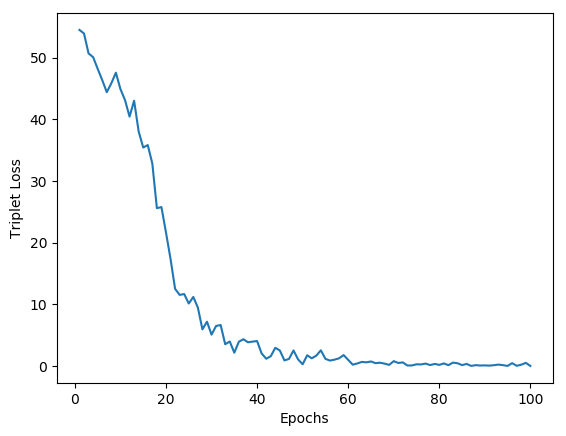

In [49]:
# Plot Triplet Loss over training period

e = list(range(1,epochs+1))

plt.plot(e,losses)
plt.xlabel('Epochs')
plt.ylabel('Triplet Loss')
plt.show()

In [22]:
test_batch = get_batch(128,0)

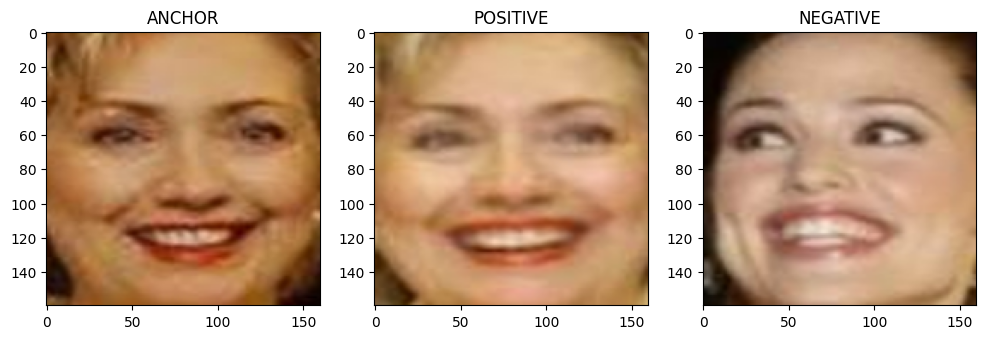

Distance between Anchor and Positive : 0.074980184
Distance between Anchor and Negative : 0.1391261


In [23]:
# Visualize Triplets with positive and negative distances
index = 0
anchor = test_batch[0][index]
positive  = test_batch[1][index]
negative = test_batch[2][index]

plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.imshow(anchor)
plt.title('ANCHOR')
plt.subplot(1,3,2)
plt.imshow(positive)
plt.title('POSITIVE')
plt.subplot(1,3,3)
plt.imshow(negative)
plt.title('NEGATIVE')

plt.show()

anchor_enc  = enc_model.predict(normalize_single(anchor).reshape(1,160,160,3))
positive_enc  = enc_model.predict(normalize_single(positive).reshape(1,160,160,3))
negative_enc  = enc_model.predict(normalize_single(negative).reshape(1,160,160,3))

print("Distance between Anchor and Positive : "+str(distance(anchor_enc,positive_enc)))
print("Distance between Anchor and Negative : "+str(distance(anchor_enc,negative_enc)))

In [67]:
# Save the encoder model weights for future use

enc_model.save('enc_model.h5')
enc_model.save_weights("enc_model_weights.h5")

In [60]:
enc_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
__________________________________________________________________________________________________
Conv2d_2a_